#Natural Language Processing Assignment: Toxic Comment Classification
##Problem Statement
In this assignment, you will work on a text classification problem using Natural Language Processing (NLP) techniques. The goal is to build a model that can identify toxic comments and classify them into multiple categories. This type of classification is crucial for content moderation on social media platforms, online forums, and other digital spaces.
##Dataset Description
The dataset comes from the Jigsaw Toxic Comment Classification Challenge on Kaggle. It contains comments from Wikipedia's talk page edits. Each comment is labeled with six different types of toxicity:

- Toxic
- Severe Toxic
- Obscene
- Threat
- Insult
- Identity Hate

This is a multi-label classification problem, meaning a single comment can belong to multiple categories simultaneously.
##Assignment Structure
The assignment is divided into the following key steps:

- Data Loading and Initial Exploration
- Exploratory Data Analysis (EDA)
- Text Preprocessing
- Feature Engineering using TF-IDF
- Model Building using Binary Relevance approach
- Model Evaluation

###Step 1: Setting Up the Environment and Downloading Data

In [41]:
# Import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [42]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riyabangera","key":"d5a92cf8021850a75165fe9784b5720b"}'}

In [43]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [44]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

jigsaw-toxic-comment-classification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [45]:
!ls

jigsaw-toxic-comment-classification-challenge.zip  test.csv		train.csv
sample_data					   test.csv.zip		train.csv.zip
sample_submission.csv.zip			   test_labels.csv.zip


In [48]:
!unzip jigsaw-toxic-comment-classification-challenge.zip

Archive:  jigsaw-toxic-comment-classification-challenge.zip
replace sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv.zip  
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv.zip            
replace test_labels.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_labels.csv.zip     
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv.zip           


In [49]:
!unzip test.csv.zip

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [50]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


This section sets up the necessary Python libraries and downloads the dataset using Kaggle API.

###Step 2: Loading and Initial Data Exploration

In [51]:
# Load training and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Define target columns
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

Here we load the data and specify our target categories for classification.

###Step 3: Exploratory Data Analysis

In [52]:
# Check basic statistics of the target variables
train_df.describe()

# Check for unlabeled comments
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) &
                            (train_df['obscene']!=1) & (train_df['threat']!=1) &
                            (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

# Check for null comments
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

Percentage of unlabelled comments is  89.83211235124176


0

This section analyzes the distribution of labels and checks for data quality issues.

###Step 4: Text Analysis

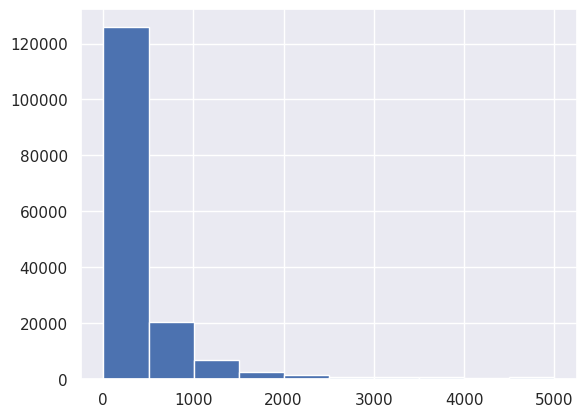

In [53]:
# Analyze comment lengths
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

# Visualize comment length distributions
sns.set()
train_df['char_length'].hist()
plt.show()

Here we analyze the length distribution of comments to understand our text data better.

###Step 5: Text Preprocessing-

In [54]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# Clean the text data
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

What Does This Code Do?
- Converts text to lowercase → text.lower()
- Expands contractions (e.g., "what's" → "what is", "can't" → "cannot")
- Removes special characters (non-word characters like punctuation)
- Removes extra spaces (multiple spaces replaced with a single space)
- Strips leading and trailing spaces

The function is applied to every row in the comment_text column of both train_df and test_df, cleaning the text before using it in a machine learning model.



###Step 6: Feature Engineering

In [55]:
# Prepare data for vectorization
train_df = train_df.drop('char_length',axis=1)
X = train_df.comment_text
test_X = test_df.comment_text

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')

# Create document-term matrices
X_dtm = vect.fit_transform(X)
test_X_dtm = vect.transform(test_X)

Here we convert text data into numerical features using TF-IDF vectorization.

###Step 7: Model Building and Evaluation

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression with Binary Relevance approach
logreg = LogisticRegression(C=12.0)

# Train and evaluate for each target
for label in cols_target:
    print(f'Processing {label}...')
    y = train_df[label]
    logreg.fit(X_dtm, y)
    y_pred_X = logreg.predict(X_dtm)
    accuracy = accuracy_score(y, y_pred_X)
    print(f'Training accuracy for {label}: {accuracy:.4f}')

Processing obscene...
Training accuracy for obscene: 0.9810
Processing insult...
Training accuracy for insult: 0.9743
Processing toxic...
Training accuracy for toxic: 0.9631
Processing severe_toxic...
Training accuracy for severe_toxic: 0.9911
Processing identity_hate...
Training accuracy for identity_hate: 0.9934
Processing threat...
Training accuracy for threat: 0.9972


This final section implements the Binary Relevance approach using Logistic Regression for multi-label classification.

Assignment Tasks for Students:


- Experiment with different text preprocessing techniques
- Try different feature engineering approaches (e.g., Count Vectorizer, Word2Vec)
